<a href="https://colab.research.google.com/github/Abhishek-TyRnT/TyRnT/blob/master/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files

uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d alessiocorrado99/animals10

100% 586M/586M [00:14<00:00, 92.0MB/s]



In [0]:
from zipfile import ZipFile

with ZipFile("animals10.zip",'r') as zipf:
  zipf.extractall()

In [0]:
%tensorflow_version 2.x

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow_addons as tda

data_dir="raw-img"
categories=["cat","Butterfly","cow","dog","elephant","hen","horse","sheep","spider","squirrel"]
categories_italian=["gatto","farfalla","mucca","cane","elefante","gallina","cavallo","pecora","ragno","scoiattolo"]

translator={english:italian for english,italian in zip(categories,categories_italian)}

paths=[os.path.join(data_dir,translator[category]) for category in categories]
files=[]
i=0
category=[]
for path in paths:
  for name in os.listdir(path):
    files.append([os.path.join(path,name),categories_italian[i]])
    category.append(categories_italian[i])
  i+=1
files=tf.convert_to_tensor(files)
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
train=[]
train_index,test_index=list(split.split(files,category))[0]
print(len(train_index))

20943


In [0]:
def translation_augmentation(image):
  x,y = np.random.randint(0,224,(2,))
  img = tf.roll(tf.roll(image,x,0),y,1)
  return img

def rotational_augmentation(image):
  rot = np.random.randint(1,5)
  img = tf.image.rot90(image,rot)
  return img

def image_generator_train():
  output=np.eye(10)
  translation_list = np.random.randint(0,len(train_index),int(0.15*len(train_index)))
  rotational_list = np.random.randint(0,len(train_index),int(0.15*len(train_index)))
  i=0

  for index in train_index:
    image=files[index][0]
    image=tf.io.read_file(image)
    image=tf.image.decode_jpeg(image,channels=3)
    image=tf.image.resize(image,size=[224,224])
    yield image/255,output[categories_italian.index(files[index][1])]
    if i in translation_list:
      img = translation_augmentation(image)
      yield img/255,output[categories_italian.index(files[index][1])]

    if i in  rotational_list:
      img =rotational_augmentation(image)
      yield img/255,output[categories_italian.index(files[index][1])]
    
    i+=1
    
def image_generator_test():
  output=np.eye(10)
  for index in test_index:
    image=files[index][0]
    image=tf.io.read_file(image)
    image=tf.image.decode_jpeg(image,channels=3)
    image=tf.image.resize(image,size=[224,224])
    yield image/255,output[categories_italian.index(files[index][1])]



In [0]:
dataset_train=tf.data.Dataset.from_generator(image_generator_train,output_types=(tf.float32,tf.float32),output_shapes=(tf.TensorShape([224,224,3]),tf.TensorShape(10)))
dataset_test=tf.data.Dataset.from_generator(image_generator_test,output_types=(tf.float32,tf.float32),output_shapes=(tf.TensorShape([224,224,3]),tf.TensorShape(10)))


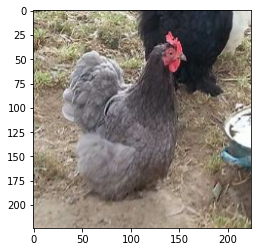

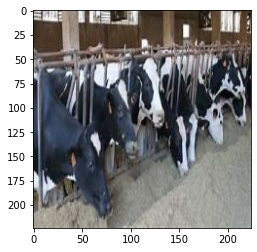

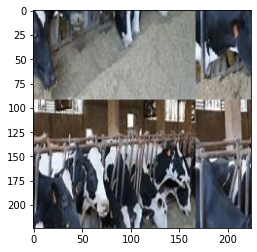

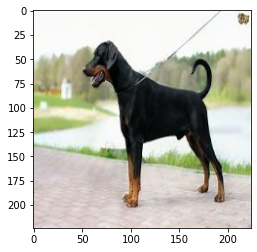

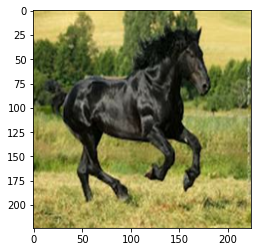

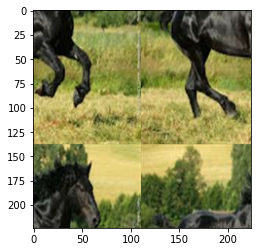

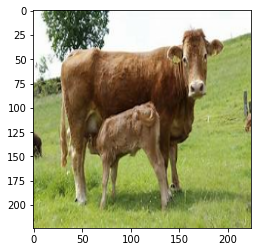

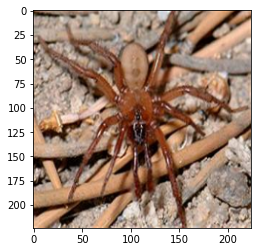

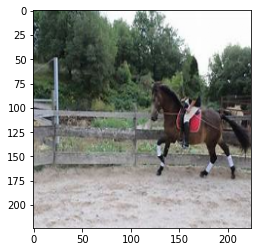

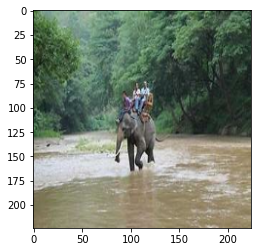

In [5]:
for image in dataset_train.take(10):
  plt.imshow(image[0])
  plt.show()

In [0]:
dataset_train=dataset_train.batch(8).shuffle(100).repeat()
dataset_test=dataset_test.batch(8).shuffle(100)

tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
(8, 10)


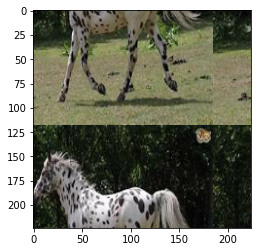

tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
(8, 10)


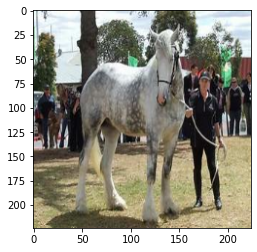

tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
(8, 10)


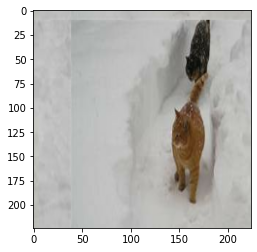

In [7]:
for image,output_1 in dataset_train.take(3):
  plt.imshow(image[0])
  print(output_1[0])
  print(output_1.shape)
  plt.show()

50 layer Resnet

In [0]:
%reload_ext tensorboard

In [0]:
from tensorflow.keras import layers

class ResLayer(layers.Layer):
  def __init__(self,channels_in,channels_out,multiplier = 1,names = None):
    super(ResLayer,self).__init__(name= names)
    self.channels_in = channels_in
    self.channels_out = channels_out
    self.multiplier = multiplier
    if self.channels_in != self.channels_out and multiplier != 1:
      self.res_conv = layers.Conv2D(filters = self.channels_out, kernel_size=(3,3),strides =2 ,padding = 'same',use_bias = False)
      strides =2
    
    elif self.channels_in != self.channels_out and multiplier == 1:
      self.res_conv = layers.Conv2D(filters = self.channels_out, kernel_size=(3,3),strides =1 ,padding = 'same',use_bias = False)
      strides =1
    else:
      strides =1
    self.conv_1 = layers.Conv2D(64*self.multiplier,kernel_size = (1,1),strides =strides ,padding = 'same',activation = 'relu')
    self.conv_2 = layers.Conv2D(64*self.multiplier,kernel_size = (3,3),padding = 'same', activation = 'relu')
    self.conv_3 = layers.Conv2D(channels_out,kernel_size = (1,1),strides = 1,padding = 'same',use_bias = False)
    self.BN = layers.BatchNormalization()
    
    
  def call(self,inputs):
    x = self.conv_1(inputs)
    x = self.conv_2(x)
    x = self.conv_3(x)
    x = self.BN(x)
    if self.channels_in != self.channels_out:
      inputs = self.res_conv(inputs)

    return tf.keras.activations.relu(x+inputs)
    

In [10]:
from tensorflow.keras import Model
from datetime import datetime
inp = tf.keras.Input(shape = (224,224,3))
network = layers.Conv2D(filters = 64,kernel_size=(7,7),strides =2,padding = 'same',activation = 'relu')(inp)
network = layers.MaxPool2D(pool_size=(3,3),strides =2,padding = 'same')(network)
network = ResLayer(64,256,names = 'Reslayer_56_1')(network)
network = ResLayer(256,256,names = 'Reslayer_56_2')(network)
network = ResLayer(256,256,names = 'Reslayer_56_3')(network)
network = ResLayer(256,512,multiplier = 2,names = 'Reslayer_28_1')(network)
network = ResLayer(512,512,multiplier = 2,names = 'Reslayer_28_2')(network)
network = ResLayer(256*2,256*2,multiplier = 2,names = 'Reslayer_28_3')(network)
network = ResLayer(256*2,256*2,multiplier = 2,names = 'Reslayer_28_4')(network)

network = ResLayer(512,1024,multiplier = 4,names = 'Reslayer_14_1')(network)
network = ResLayer(1024,1024,multiplier = 4,names = 'Reslayer_14_2')(network)
network = ResLayer(1024,1024,multiplier = 4,names = 'Reslayer_14_3')(network)
network = ResLayer(1024,1024,multiplier = 4,names = 'Reslayer_14_4')(network)
network = ResLayer(1024,1024,multiplier = 4,names = 'Reslayer_14_5')(network)
network = ResLayer(1024,1024,multiplier = 4,names = 'Reslayer_14_6')(network)

network = ResLayer(1024,2048,multiplier = 8,names = 'Reslayer_7_1')(network)
network = ResLayer(2048,2048,multiplier = 8,names = 'Reslayer_7_2')(network)
network = ResLayer(2048,2048,multiplier = 8,names = 'Reslayer_7_3')(network)

network = layers.AvgPool2D(pool_size=network.shape[1:3])(network)
network = layers.Flatten()(network)
network = layers.Dropout(0.5)(network)
network = layers.Dense(10,'softmax')(network)

Resnet50 = Model(inputs=inp,outputs=network)
Resnet50.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
Reslayer_56_1 (ResLayer)     (None, 56, 56, 256)       205952    
_________________________________________________________________
Reslayer_56_2 (ResLayer)     (None, 56, 56, 256)       70784     
_________________________________________________________________
Reslayer_56_3 (ResLayer)     (None, 56, 56, 256)       70784     
_________________________________________________________________
Reslayer_28_1 (ResLayer)     (None, 28, 28, 512)       142771

In [0]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
class learning_schedule(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if epoch == 25:
      optimizer.learning_rate.assign(1e-4)
    elif epoch == 35:
      optimizer.learning_rate.assign(1e-5)
    elif epoch == 45:
      optimizer.learning_rate.assign(1e-6)



In [22]:

Resnet50.compile(optimizer=optimizer,loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),metrics=['accuracy'])
Resnet50.fit(dataset_train,steps_per_epoch=1000/2,epochs =60,callbacks = learning_schedule(),validation_data=dataset_test,validation_steps=50)

Epoch 1/60
500/500 [==============================] - 71s 142ms/step - loss: 2.9008 - accuracy: 0.1600 - val_loss: 2.2684 - val_accuracy: 0.1800
Epoch 2/60
500/500 [==============================] - 71s 141ms/step - loss: 2.3474 - accuracy: 0.1922 - val_loss: 2.9143 - val_accuracy: 0.1075
Epoch 3/60
500/500 [==============================] - 71s 141ms/step - loss: 2.2541 - accuracy: 0.2025 - val_loss: 2.1911 - val_accuracy: 0.1875
Epoch 4/60
500/500 [==============================] - 70s 141ms/step - loss: 2.2063 - accuracy: 0.2245 - val_loss: 2.8943 - val_accuracy: 0.0800
Epoch 5/60
500/500 [==============================] - 70s 141ms/step - loss: 2.1781 - accuracy: 0.2310 - val_loss: 2.2701 - val_accuracy: 0.1825
Epoch 6/60
500/500 [==============================] - 70s 139ms/step - loss: 2.1543 - accuracy: 0.2445 - val_loss: 2.4813 - val_accuracy: 0.1500
Epoch 7/60
500/500 [==============================] - 70s 139ms/step - loss: 2.1213 - accuracy: 0.2760 - val_loss: 2.3863 - val_ac

In [0]:
checkpoint = tf.train.Checkpoint(optmizer = optimizer,net =Resnet50)
#checkpoint.save('/content/drive/My Drive/ckpt')

In [13]:
checkpoint.restore('/content/drive/My Drive/ckpt-1')

In [16]:
Resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4,epsilon=1e-3),loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),metrics=['accuracy'])
#Resnet50.fit(dataset_train,steps_per_epoch=1000/2,epochs =20,validation_data=dataset_test,validation_steps=200)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fba04aabf98> and <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb98fc5fc88>).


tf.Tensor(
[[0.18469389 0.01049348 0.01443778 0.44239607 0.01710414 0.01466128
  0.02010112 0.01462194 0.24386157 0.03762866]
 [0.45586237 0.10258761 0.00895265 0.05807153 0.00514538 0.05154563
  0.00359511 0.01718006 0.2563372  0.04072246]
 [0.39913383 0.12483591 0.00619701 0.04692421 0.00773695 0.12113178
  0.00387009 0.01515862 0.11840215 0.15660943]
 [0.10453828 0.05698074 0.00451233 0.03327634 0.01112043 0.00863802
  0.0050297  0.01047398 0.48431808 0.2811121 ]
 [0.05338261 0.00211844 0.02917465 0.7584934  0.02333493 0.01671674
  0.01572732 0.03556702 0.01161014 0.05387479]
 [0.06819054 0.17228703 0.04512462 0.03738391 0.07164728 0.05911769
  0.16326249 0.02327229 0.33541107 0.0243031 ]
 [0.03662216 0.01415934 0.00949653 0.00933162 0.00823722 0.04277235
  0.00438154 0.0331452  0.6110426  0.23081143]
 [0.0633636  0.00163703 0.00518332 0.18955632 0.01224984 0.14739369
  0.00447676 0.09150739 0.003339   0.48129308]], shape=(8, 10), dtype=float32)


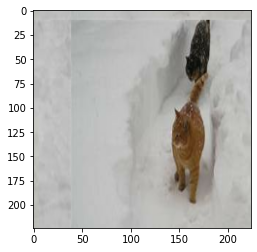

dog


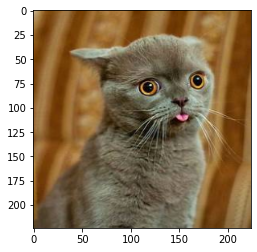

cat


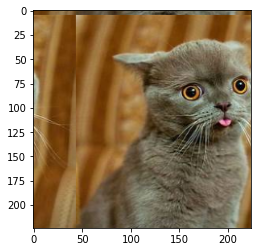

cat


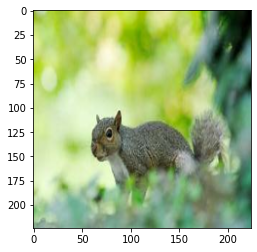

spider


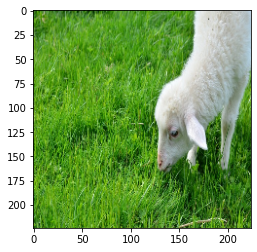

dog


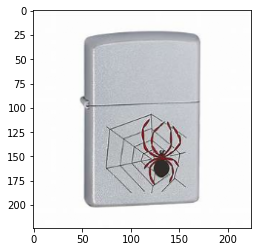

spider


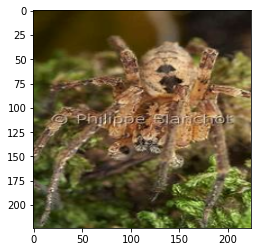

spider


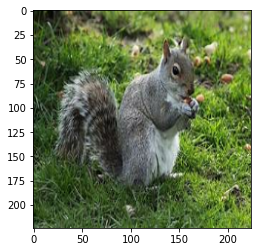

squirrel


In [14]:
logits=Resnet50(image)
print(logits)

for i in range(8):
  plt.imshow(image[i])
  plt.show()
  print(categories[tf.argmax(logits[i])])

In [17]:
Resnet50.evaluate(dataset_test)

655/655 [==============================] - 41s 62ms/step - loss: 1.1841 - accuracy: 0.7135


[1.1840842962265015, 0.7135217785835266]

spider


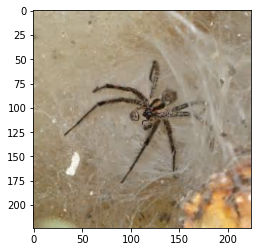

dog


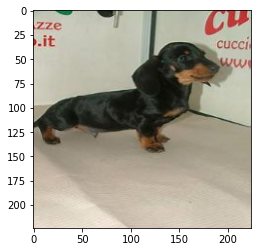

spider


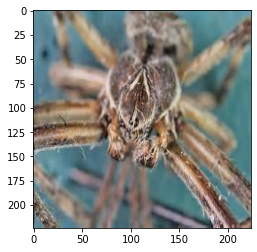

elephant


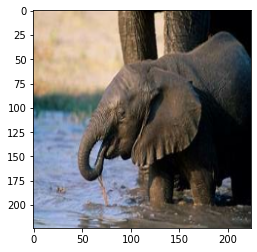

elephant


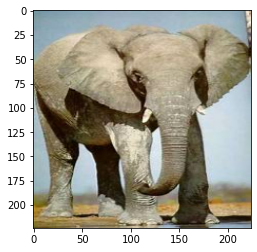

Butterfly


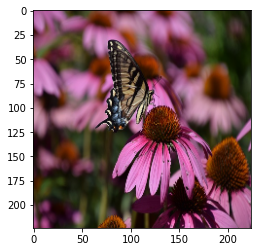

Butterfly


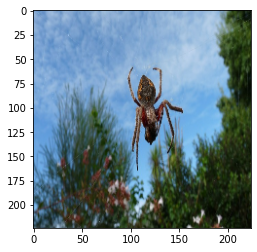

dog


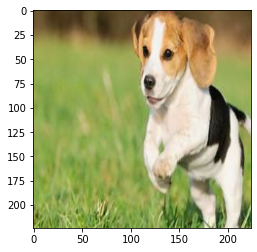

In [20]:
for image,value in dataset_test.take(1):
  image=image

result=Resnet50(image)
for i in range(8):
  plt.imshow(image[i])
  print(categories[tf.argmax(result[i])])
  plt.show()

In [18]:
Resnet50.save('/content/drive/My Drive/Resnet50',include_optimizer=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Resnet50/assets
